In [1]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (406/406), done.
remote: Total 408 (delta 2), reused 408 (delta 2), pack-reused 0
Receiving objects: 100% (408/408), 45.03 MiB | 62.14 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
!ls

ants_and_bees  sample_data


In [6]:
!ls ants_and_bees

train  val


In [7]:
!ls ants_and_bees/train

ants  bees


In [8]:
!ls ants_and_bees/train/ants

 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    518773929_7

In [0]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])

transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [10]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ['ant', 'bee']

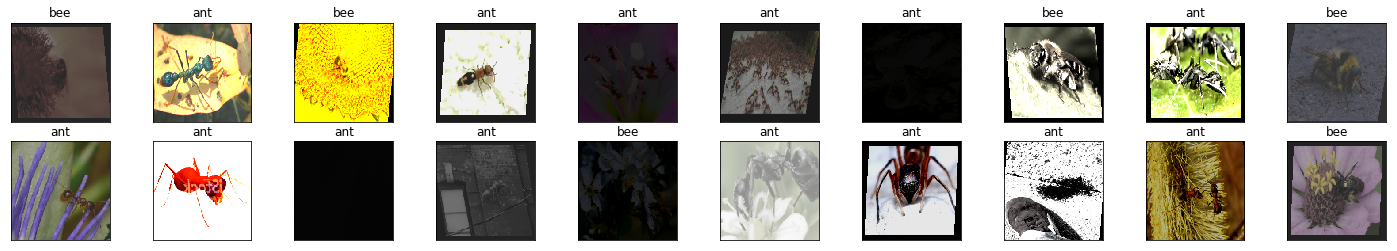

In [13]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [14]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 125360704.45it/s]


In [15]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
for param in model.features.parameters():
  param.requires_grad = False

In [17]:
import torch.nn as nn

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [19]:
epochs = 5

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_accuracy = running_corrects.float()/len(training_loader.dataset)
    
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_accuracy)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_accuracy = val_running_corrects.float()/len(validation_loader.dataset)
    
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_accuracy)
    print('epoch:', e)
    print('Training Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy.item(), val_epoch_loss, val_epoch_accuracy.item()))

epoch: 0
Training Loss: 0.0302, Training Accuracy: 0.6762, Validation Loss: 0.0161, Validation Accuracy: 0.8758
epoch: 1
Training Loss: 0.0182, Training Accuracy: 0.8197, Validation Loss: 0.0118, Validation Accuracy: 0.9346
epoch: 2
Training Loss: 0.0116, Training Accuracy: 0.8811, Validation Loss: 0.0162, Validation Accuracy: 0.9085
epoch: 3
Training Loss: 0.0111, Training Accuracy: 0.9180, Validation Loss: 0.0194, Validation Accuracy: 0.9150
epoch: 4
Training Loss: 0.0124, Training Accuracy: 0.8811, Validation Loss: 0.0224, Validation Accuracy: 0.9020


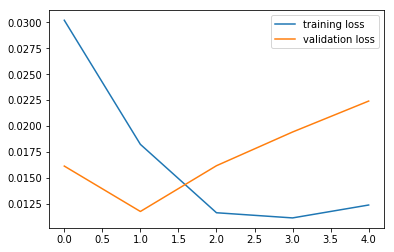

In [20]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

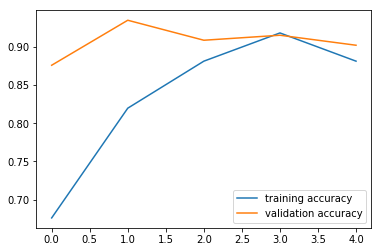

In [21]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:
# !pip3 install pillow==4.0.0

<Response [200]>


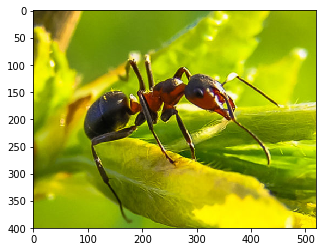

In [23]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://publiceyemaritzburg.co.za/wp-content/uploads/sites/53/2018/09/feature-3-2-520x400.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

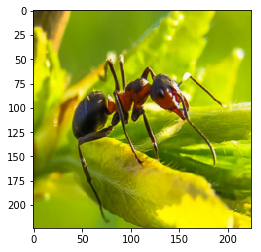

In [24]:
img = transform(img)
plt.imshow(im_convert(img))

In [25]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


<Response [200]>


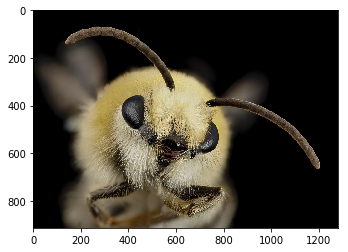

In [26]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://assets.atlasobscura.com/media/W1siZiIsInVwbG9hZHMvYXNzZXRzL2E1M2UxYjU4ZTk0N2Q2ZmNmNl8xNTQzNjU5MjU1N185MmU4NGVhMWNmX2suanBnIl0sWyJwIiwiY29udmVydCIsIiJdLFsicCIsImNvbnZlcnQiLCItcXVhbGl0eSA4MSAtYXV0by1vcmllbnQiXSxbInAiLCJ0aHVtYiIsIjEyODB4PiJdXQ/15436592557_92e84ea1cf_k.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

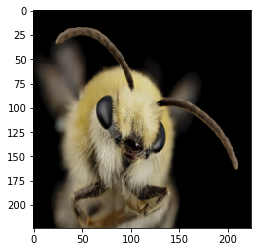

In [27]:
img = transform(img)
plt.imshow(im_convert(img))

In [28]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


<Response [200]>


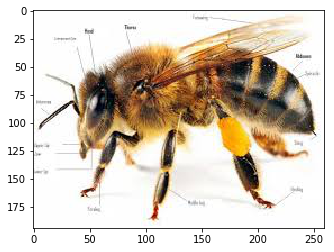

In [29]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRTBoi-Jsq6BR1-nogR2VankoDWnMTMzcayaLx_f9UHTPgteh_ZFA'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

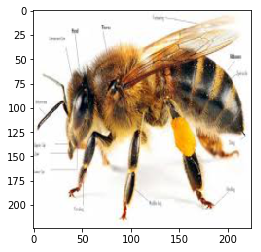

In [30]:
img = transform(img)
plt.imshow(im_convert(img))

In [31]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


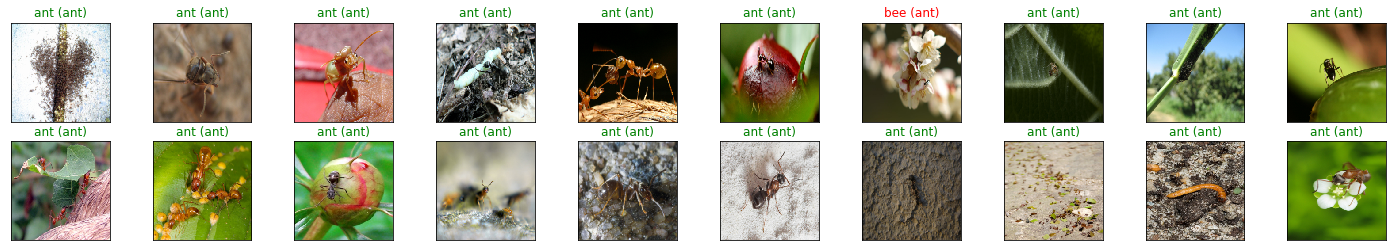

In [32]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(classes[preds[idx].item()], classes[labels[idx].item()]), color=("green" if preds[idx]==labels[idx] else "red"))